# Interp on my GPT-2 Flax Implementation

In [19]:
# Imports
import jax
import jax.numpy as jnp
from jax import random
from model import GPT, GPTConfig
import os

import penzai
from __future__ import annotations

import os
import gc

import jax
import jax.numpy as jnp
import numpy as np
import orbax.checkpoint
import optax
from jax.experimental import mesh_utils

import treescope
import penzai
from penzai import pz

import sentencepiece as spm

from penzai.models import transformer
from penzai.models import simple_mlp, transformer

from penzai.toolshed import token_visualization
from penzai.toolshed import basic_training
from penzai.toolshed import jit_wrapper
from penzai.nn.layer import Layer
import dataclasses
treescope.basic_interactive_setup(autovisualize_arrays=True)


## Load model from checkpoint

In [20]:
from flax.training import checkpoints

config = GPTConfig(
    vocab_size=50257,  # Updated for GPT-2 BPE
    block_size=256,  # or whichever block size you used
    n_layer=4,
    n_head=4,
    n_embd=256,
    embd_pdrop=0.0,  # 0 for inference
    resid_pdrop=0.0,
    attn_pdrop=0.0,
)

# Load your model from a checkpoint directory
ckpt_dir = os.path.abspath("checkpoints/")

model = GPT(config)
params = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, step=201000,target=None)
if params is None:
    raise ValueError(f"No checkpoint found in {ckpt_dir}")


### Count number of parameters

In [21]:

# Create a dummy input. The shape should match the model's expected input shape.
# Here we use a batch size of 1 and sequence length equal to block_size.
dummy_input = jnp.zeros((1, config.block_size), dtype=jnp.int32)

# Initialize the model parameters with a PRNG key
key = random.PRNGKey(0)

# Function to count total parameters
def count_params(params):
    # Use jax.tree_util.tree_leaves to get all arrays in the nested dict
    return sum(x.size for x in jax.tree_util.tree_leaves(params))


total_params = count_params(params)
print("Total number of parameters:", total_params)

Total number of parameters: 28891136


## Generating completions via Inference

We can yield the completion token-by-token...

In [22]:
from inference import generate_text
from bpe import BPETokenizerJax

# Example prompt
prompt = "Shakespeare wrote:"
prompt = "You are gentlemen of brave metal; you would lift the moon out of her sphere, if she would continue in it five weeks without changing."
prompt = prompt +  prompt
tokenizer = BPETokenizerJax()

# Tokenize the prompt via BPE
# The tokenizer(...) call returns a list of jnp arrays (one per input string).
encoded_list = tokenizer(prompt, return_tensors="jax")
# For a single prompt string, encoded_list is a list of length 1.
idx = encoded_list[0]  # shape (sequence_length,)

# Add a batch dimension (shape: (1, seq_len))
idx_jax = idx[jnp.newaxis, :]

# Initialize RNG key
rng = jax.random.PRNGKey(0)

print("Prompt:", prompt)

print("Generated text:")

# Generate text
for new_token in model.apply(
        {"params": params},
        idx_jax,
        max_new_tokens=5,
        rng=rng,
        temperature=0.7,
        do_sample=True,
        top_k=None,
        method=model.generate_yield,
    ):
    # Decode the generated token
    generated_text = tokenizer.decode(new_token)
    print(generated_text, end="")



Prompt: You are gentlemen of brave metal; you would lift the moon out of her sphere, if she would continue in it five weeks without changing.You are gentlemen of brave metal; you would lift the moon out of her sphere, if she would continue in it five weeks without changing.
Generated text:


SEBAST

Or write an external function which generates that completion token-by-token...

In [23]:
import jax
import jax.numpy as jnp
import flax.linen as nn

def external_generate(
    model: nn.Module,
    params: dict,
    idx: jnp.ndarray,
    max_new_tokens: int,
    rng: jax.random.PRNGKey,
    temperature: float = 1.0,
    do_sample: bool = False,
    top_k: int = None,
):
    """
    Generate tokens from the model using only the __call__ method.

    Args:
        model: The GPT model (an instance of nn.Module) with a __call__ method.
        params: The parameters of the model.
        idx: jnp.ndarray of shape (B, T) containing the initial token indices.
        max_new_tokens: Number of tokens to generate.
        rng: A JAX random key.
        temperature: Temperature factor for sampling.
        do_sample: If True, sample from the distribution; otherwise, take argmax.
        top_k: If provided, restrict sampling to the top_k logits.

    Yields:
        Generated tokens one at a time (each of shape (1,)).
    """
    for _ in range(max_new_tokens):
        # Crop the context to the model's block size if necessary
        if idx.shape[1] > model.config.block_size:
            idx_cond = idx[:, -model.config.block_size:]
        else:
            idx_cond = idx

        # FIX: Wrap the parameters in {"params": params} so that the "params" collection is set correctly.
        logits, _ = model.apply({"params": params}, idx_cond, deterministic=True)

        # Focus on the logits for the last token in the sequence and scale by temperature
        logits = logits[:, -1, :] / temperature

        # Optionally, apply top-k filtering
        if top_k is not None:
            # Get the top_k logits and determine the minimum value among them
            top_logits, _ = jax.lax.top_k(logits, top_k)
            k_threshold = jnp.min(top_logits, axis=-1, keepdims=True)
            # Replace logits not in the top_k with -infinity
            logits = jnp.where(logits < k_threshold, -jnp.inf, logits)

        # Convert logits to probabilities
        probs = nn.softmax(logits, axis=-1)

        # Sample the next token (or take the argmax)
        rng, subkey = jax.random.split(rng)
        if do_sample:
            next_token = jax.random.categorical(subkey, jnp.log(probs), axis=-1)
        else:
            next_token = jnp.argmax(probs, axis=-1)

        # Ensure the next token has shape (B, 1) and append it to the current sequence
        next_token = next_token[:, None]
        idx = jnp.concatenate([idx, next_token], axis=1)
        yield next_token[0]

# Example usage:
print("Prompt:", prompt)
print("Generated text:")

for new_token in external_generate(
        model=model,
        params=params,  # This should be the inner parameters; external_generate now wraps them correctly.
        idx=idx_jax,
        max_new_tokens=1,
        rng=rng,
        temperature=0.8,
    ):
    # Decode the generated token
    generated_text = tokenizer.decode(new_token)
    print(generated_text, end="")


Prompt: You are gentlemen of brave metal; you would lift the moon out of her sphere, if she would continue in it five weeks without changing.You are gentlemen of brave metal; you would lift the moon out of her sphere, if she would continue in it five weeks without changing.
Generated text:



## Unflaxify the Model for Penzai

In [24]:
from penzai.toolshed.unflaxify import unflaxify_apply

# Create dummy input
dummy_input = jnp.ones((1, config.block_size), dtype=jnp.int32)
rng = jax.random.PRNGKey(42)
init_rng, dropout_rng = jax.random.split(rng)

# Initialize
variables = model.init(
    {
        "params": init_rng,
        "dropout": dropout_rng
    },
    idx=dummy_input,
    deterministic=False
)
    
# Intercept the forward pass
pz_model = unflaxify_apply(
    module=model,
    variables=variables,
    idx=dummy_input,     # our forward arguments
    deterministic=True   # example kwarg
)

pz_model

InterceptedFlaxModuleMethod(
  module=GPT(
    config=<model.GPTConfig object at 0x7f97b443d2d0>, # Repeated python obj at 0x7f97b443d2d0
    name=None,
  ),
  method_name='__call__',
  scope_data=None,
  submodule_calls={(0, 'wte.__call__'): InterceptedFlaxModuleMethod(module=Embed(num_embeddings=50257, features=256, dtype=None, param_dtype=jax.numpy.float32, embedding_init=<function normal.<locals>.init at 0x7f97b42dbc40>, name='wte'), method_name='__call__', scope_data=InterceptedFlaxScopeData(parameters={'embedding': Parameter(label='wte.embedding', value=<jax.Array float32(50257, 256)- too large to summarize.>, metadata={})}, variables={}, immutable_variables={}, rng_names=frozenset({})), submodule_calls={}), (1, 'drop.__call__'): InterceptedFlaxModuleMethod(module=Dropout(rate=0.0, broadcast_dims=(), deterministic=None, rng_collection='dropout', name='drop'), method_name='__call__', scope_data=None, submodule_calls={}), (2, 'h_0.__call__'): InterceptedFlaxModuleMethod(module=Block(config=<model.GPTConfig object at 0x7f97b443d2d0>, name='h_0'), method_name='__call__', scope_data=None, submodule_calls={(0, 'ln_1.__call__'): InterceptedFlaxModuleMethod(module=LayerNorm(features=256, epsilon=1e-05, use_bias=True, use_scale=True, reduction_axes=-1, dtype=jax.numpy.float32, param_dtype=jax.numpy.float32, name='ln_1'), method_name='__call__', scope_data=InterceptedFlaxScopeData(parameters={'bias': Parameter(label='h_0.ln_1.bias', value=<jax.Array float32(256,) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:256>, metadata={}), 'scale': Parameter(label='h_0.ln_1.scale', value=<jax.Array float32(256,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:256>, metadata={})}, variables={}, immutable_variables={}, rng_names=frozenset({})), submodule_calls={}), (1, 'ln_2.__call__'): InterceptedFlaxModuleMethod(module=LayerNorm(features=256, epsilon=1e-05, use_bias=True, use_scale=True, reduction_axes=-1, dtype=jax.numpy.float32, param_dtype=jax.numpy.float32, name='ln_2'), method_name='__call__', scope_data=InterceptedFlaxScopeData(parameters={'bias': Parameter(label='h_0.ln_2.bias', value=<jax.Array float32(256,) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:256>, metadata={}), 'scale': Parameter(label='h_0.ln_2.scale', value=<jax.Array float32(256,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:256>, metadata={})}, variables={}, immutable_variables={}, rng_names=frozenset({})), submodule_calls={}), (2, 'attn.__call__'): InterceptedFlaxModuleMethod(module=CausalSelfAttention(config=<model.GPTConfig object at 0x7f97b443d2d0>, name='attn'), method_name='__call__', scope_data=None, submodule_calls={(0, 'c_attn.__call__'): InterceptedFlaxModuleMethod(module=Dense(features=768, use_bias=True, dtype=None, param_dtype=jax.numpy.float32, precision=None, kernel_init=<function normal.<locals>.init at 0x7f97b431c540>, bias_init=zeros, dot_general=None, dot_general_cls=None, name='c_attn'), method_name='__call__', scope_data=InterceptedFlaxScopeData(parameters={'bias': Parameter(label='h_0.attn.c_attn.bias', value=<jax.Array float32(768,) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:768>, metadata={}), 'kernel': Parameter(label='h_0.attn.c_attn.kernel', value=<jax.Array float32(256, 768) ≈3.9e-06 ±0.02 [≥-0.091, ≤0.1] nonzero:196_608>, metadata={})}, variables={}, immutable_variables={}, rng_names=frozenset({})), submodule_calls={}), (1, 'attn_dropout.__call__'): InterceptedFlaxModuleMethod(module=Dropout(rate=0.0, broadcast_dims=(), deterministic=None, rng_collection='dropout', name='attn_dropout'), method_name='__call__', scope_data=None, submodule_calls={}), (2, 'c_proj.__call__'): InterceptedFlaxModuleMethod(module=Dense(features=256, use_bias=True, dtype=None, param_dtype=jax.numpy.float32, precision=None, kernel_init=<function normal.<locals>.init at 0x7f97b431c7c0>, bias_init=zeros, dot_general=None, dot_general_cls=None, name='c_proj'), method_name='__call__', scope_data=InterceptedFlaxScopeData(parameters={'bias': Parameter(label='h_0.attn.c_proj.bias', value=<jax.Array float32(256,) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:256>, metadata

# Visualize Attention Patterns in the Causal Self-Attention

Looking for induction heads, we start by creating a repeated sequence...

In [25]:

repeated_sequence_prompt = "You are gentlemen of brave metal; you would lift the moon out of her sphere, if she would continue in it five weeks without changing."

# repeat the prompt twice
repeated_sequence = repeated_sequence_prompt + repeated_sequence_prompt

# Tokenize the prompt via BPE
tokens = tokenizer(repeated_sequence)

tokens[0]



<jax.Array int32(56,) [≥11, ≤28_527] nonzero:56
  <Arrayviz rendering>
| Device: GPU 0>

In [26]:
from penzai.toolshed.unflaxify import ArgsAndKwargs

# Wrap tokens and tag with "batch" and "seq"
token_seq = pz.nx.wrap(tokens).tag("batch", "seq")

# Remove the tags and unwrap to get a plain JAX array
token_seq_plain = token_seq.untag("batch", "seq").unwrap()

# Now capture the plain array inside an ArgsAndKwargs instance.
token_seq_wrapped = ArgsAndKwargs.capture(token_seq_plain)

# Pass the wrapped, plain array to the model.
logits = pz_model(token_seq_wrapped)[0][0] # [0] removes the batch dim 

logits

# Find the index of the highest logit
highest_logit_index = jnp.argmax(logits, axis=-1)
print(highest_logit_index)

[31140 24024 46989 25530  8391  8440 13103 12464 45107 21836 46963 27975
 42307 41994 34993 33784 43099 32990 42195  4178  8515 34568 26185 17809
 21668 18316 17019 12464 19059 26870 42307 38656  7689  8440 13103 12464
 45631 21836 27975 27975 38316 41994 34993 33784 43099 32990 42195 45631
  8515 34568 26185 17809 21668 38316 17019 12464]


In [27]:
logits =pz.nx.wrap(logits).tag("seq", "vocabulary")


# Map softmax over the vocabulary
log_probs = pz.nx.nmap(jax.nn.log_softmax)(
    logits.untag("vocabulary")
).tag("vocabulary")
log_probs


<NamedArray float32(| seq:56, vocabulary:50257) ≈-1.1e+01 ±0.32 [≥-1.3e+01, ≤-9.4] nonzero:2_814_392 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [28]:
# Indexing with a dictionary indexes the named axes; pz.slice helps slice them.
sliced_preds = log_probs[{"seq": pz.slice[:-1]}]
correct_next_token = token_seq[{"seq": pz.slice[1:]}]


log_prob_of_correct_next = sliced_preds[{"vocabulary": correct_next_token}]
log_prob_of_correct_next

<NamedArray float32(| seq:55, batch:1) ≈-1.1e+01 ±0.22 [≥-1.1e+01, ≤-1e+01] nonzero:55 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [29]:
# Unbind the names, slice the positional array, rebind the names if needed.
sliced_preds = log_probs.untag("seq")[:-1].tag("seq")
correct_next_token = token_seq.untag("seq")[1:].tag("seq")
sliced_preds.untag("vocabulary")[correct_next_token]

<NamedArray float32(| seq:55, batch:1) ≈-1.1e+01 ±0.22 [≥-1.1e+01, ≤-1e+01] nonzero:55 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [30]:
import penzai
from penzai import pz
from penzai.core.variables import StateVariable
from penzai.nn.layer import Layer
from typing import Any
from penzai.toolshed.unflaxify import InterceptedFlaxModuleMethod

@pz.pytree_dataclass  # <- This tags our class as being a Python dataclass and a JAX pytree node.
class DisplayIntermediateValue(pz.nn.Layer):  # <- pz.nn.Layer is the base class of Penzai layers.
  def __call__(self, intermediate_value, **unused_side_inputs):
    # print("Intermediate value:", intermediate_value)
    print(intermediate_value.shape)
    wrapped_intermediate_value = intermediate_value[0]
    # Show the value:
    pz.show(wrapped_intermediate_value)
    # And return it unchanged.
    return intermediate_value

def combined_call(original_submodule):
    # Create a wrapper that calls `original_submodule(...)`,
    # then does DisplayIntermediateValue or any post-processing.

    def new_callable(*args, **kwargs):
        output = original_submodule(*args, **kwargs)
        # do whatever side effect or instrumentation we want
        DisplayIntermediateValue()(output)  # e.g. just call it
        return output

    return new_callable

patched_selection = (
    pz.select(pz_model)
      .at_subtrees_where(
          lambda node:
              isinstance(node, InterceptedFlaxModuleMethod)
              and getattr(node.module, "__class__", None).__name__ == "Dropout"
              and node.module.name == 'attn_dropout'
      )
      
)


patched_model = patched_selection.apply(
          lambda method: combined_call(method),
      )

patched_selection


Selection(
  selected_by_path=OrderedDict({(GetAttrKey(name='submodule_calls'), DictKey(key=(2, 'h_0.__call__')), GetAttrKey(name='submodule_calls'), DictKey(key=(2, 'attn.__call__')), GetAttrKey(name='submodule_calls'), DictKey(key=(1, 'attn_dropout.__call__'))): InterceptedFlaxModuleMethod(module=Dropout(rate=0.0, broadcast_dims=(), deterministic=None, rng_collection='dropout', name='attn_dropout'), method_name='__call__', scope_data=None, submodule_calls={}), (GetAttrKey(name='submodule_calls'), DictKey(key=(3, 'h_1.__call__')), GetAttrKey(name='submodule_calls'), DictKey(key=(2, 'attn.__call__')), GetAttrKey(name='submodule_calls'), DictKey(key=(1, 'attn_dropout.__call__'))): InterceptedFlaxModuleMethod(module=Dropout(rate=0.0, broadcast_dims=(), deterministic=None, rng_collection='dropout', name='attn_dropout'), method_name='__call__', scope_data=None, submodule_calls={}), (GetAttrKey(name='submodule_calls'), DictKey(key=(4, 'h_2.__call__')), GetAttrKey(name='submodule_calls'), DictKey(key=(2, 'attn.__call__')), GetAttrKey(name='submodule_calls'), DictKey(key=(1, 'attn_dropout.__call__'))): InterceptedFlaxModuleMethod(module=Dropout(rate=0.0, broadcast_dims=(), deterministic=None, rng_collection='dropout', name='attn_dropout'), method_name='__call__', scope_data=None, submodule_calls={}), (GetAttrKey(name='submodule_calls'), DictKey(key=(5, 'h_3.__call__')), GetAttrKey(name='submodule_calls'), DictKey(key=(2, 'attn.__call__')), GetAttrKey(name='submodule_calls'), DictKey(key=(1, 'attn_dropout.__call__'))): InterceptedFlaxModuleMethod(module=Dropout(rate=0.0, broadcast_dims=(), deterministic=None, rng_collection='dropout', name='attn_dropout'), method_name='__call__', scope_data=None, submodule_calls={})}),
  remainder=InterceptedFlaxModuleMethod(
    module=GPT(
      config=<model.GPTConfig object at 0x7f97b443d2d0>, # Repeated python obj at 0x7f97b443d2d0
      name=None,
    ),
    method_name='__call__',
    scope_data=None,
    submodule_calls={(0, 'wte.__call__'): InterceptedFlaxModuleMethod(module=Embed(num_embeddings=50257, features=256, dtype=None, param_dtype=jax.numpy.float32, embedding_init=<function normal.<locals>.init at 0x7f97b42dbc40>, name='wte'), method_name='__call__', scope_data=InterceptedFlaxScopeData(parameters={'embedding': Parameter(label='wte.embedding', value=<jax.Array float32(50257, 256)- too large to summarize.>, metadata={})}, variables={}, immutable_variables={}, rng_names=frozenset({})), submodule_calls={}), (1, 'drop.__call__'): InterceptedFlaxModuleMethod(module=Dropout(rate=0.0, broadcast_dims=(), deterministic=None, rng_collection='dropout', name='drop'), method_name='__call__', scope_data=None, submodule_calls={}), (2, 'h_0.__call__'): InterceptedFlaxModuleMethod(module=Block(config=<model.GPTConfig object at 0x7f97b443d2d0>, name='h_0'), method_name='__call__', scope_data=None, submodule_calls={(0, 'ln_1.__call__'): InterceptedFlaxModuleMethod(module=LayerNorm(features=256, epsilon=1e-05, use_bias=True, use_scale=True, reduction_axes=-1, dtype=jax.numpy.float32, param_dtype=jax.numpy.float32, name='ln_1'), method_name='__call__', scope_data=InterceptedFlaxScopeData(parameters={'bias': Parameter(label='h_0.ln_1.bias', value=<jax.Array float32(256,) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:256>, metadata={}), 'scale': Parameter(label='h_0.ln_1.scale', value=<jax.Array float32(256,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:256>, metadata={})}, variables={}, immutable_variables={}, rng_names=frozenset({})), submodule_calls={}), (1, 'ln_2.__call__'): InterceptedFlaxModuleMethod(module=LayerNorm(features=256, epsilon=1e-05, use_bias=True, use_scale=True, reduction_axes=-1, dtype=jax.numpy.float32, param_dtype=jax.numpy.float32, name='ln_2'), method_name='__call__', scope_data=InterceptedFlaxScopeData(parameters={'bias': Parameter(label='h_0.ln_2.bias', value=<jax.Array float32(256,) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:256>, metadata={}), 'scale': Parameter(label='h_0.ln_2.scale', value=<jax.Array float32(256,) ≈1.0 ±0.

In [31]:
repeated_sequence_prompt = "You are gentlemen of brave metal"

# repeat the prompt twice
repeated_sequence_prompt = repeated_sequence_prompt + "|" + repeated_sequence_prompt

# Tokenize the prompt via BPE
tokens = tokenizer(repeated_sequence_prompt)

# Wrap tokens and tag with "batch" and "seq"
token_seq = pz.nx.wrap(tokens).tag("batch", "seq")

# Remove the tags and unwrap to get a plain JAX array
token_seq_plain = token_seq.untag("batch", "seq").unwrap()

# Now capture the plain array inside an ArgsAndKwargs instance.
token_seq_wrapped = ArgsAndKwargs.capture(token_seq_plain)


logits = patched_model(token_seq_wrapped)



(1, 4, 13, 13)


<jax.Array float32(4, 13, 13) ≈0.077 ±0.11 [≥0.0, ≤1.0] zero:312 nonzero:364
  <Arrayviz rendering>
| Device: GPU 0>

(1, 4, 13, 13)


<jax.Array float32(4, 13, 13) ≈0.077 ±0.11 [≥0.0, ≤1.0] zero:312 nonzero:364
  <Arrayviz rendering>
| Device: GPU 0>

(1, 4, 13, 13)


<jax.Array float32(4, 13, 13) ≈0.077 ±0.11 [≥0.0, ≤1.0] zero:312 nonzero:364
  <Arrayviz rendering>
| Device: GPU 0>

(1, 4, 13, 13)


<jax.Array float32(4, 13, 13) ≈0.077 ±0.11 [≥0.0, ≤1.0] zero:312 nonzero:364
  <Arrayviz rendering>
| Device: GPU 0>

# Visualize Transformation under LayerNorm

In [66]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from penzai.toolshed.isolate_submodel import call_and_extract_submodel
from penzai.toolshed.unflaxify import ArgsAndKwargs

# Step 1: Extract the LayerNorm submodel
layer_norm_selection = (
    pz.select(pz_model)
      .at_subtrees_where(
          lambda node:
              isinstance(node, InterceptedFlaxModuleMethod)
              and getattr(node.module, "__class__", None).__name__ == "LayerNorm"
              and node.module.name == 'ln_1'
      ).pick_nth_selected(0)
)

repeated_sequence_prompt = "You are gentlemen of brave metal"
repeated_sequence_prompt = repeated_sequence_prompt + "|" + repeated_sequence_prompt
tokens = tokenizer(repeated_sequence_prompt)

token_seq = pz.nx.wrap(tokens).tag("batch", "seq")
token_seq_plain = token_seq.untag("batch", "seq").unwrap()
token_seq_wrapped = ArgsAndKwargs.capture(token_seq_plain)

isolated_layer_norm = call_and_extract_submodel(layer_norm_selection, token_seq_wrapped)




def layer_norm(new_args):
    result = isolated_layer_norm.submodel.stateless_call(
        isolated_layer_norm.initial_var_values,
        new_args,
        **isolated_layer_norm.saved_side_inputs
    )

    # Extract centered and normalized points
    points_normalized_np = np.array(result[0][0][0])  # Projected onto hypersphere
    points_centered_np = np.array(result[0][1][0])  # Mapped onto hyperplane

    return points_normalized_np, points_centered_np


isolated_layer_norm

IsolatedSubmodel(
  submodel=InterceptedFlaxModuleMethod(
    module=LayerNorm(features=256, epsilon=1e-05, use_bias=True, use_scale=True, reduction_axes=-1, dtype=jax.numpy.float32, param_dtype=jax.numpy.float32, name='ln_1'),
    method_name='__call__',
    scope_data=InterceptedFlaxScopeData(parameters={'bias': ParameterValue(label='h_0.ln_1.bias', value=<jax.Array float32(256,) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:256>, metadata={}), 'scale': ParameterValue(label='h_0.ln_1.scale', value=<jax.Array float32(256,) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:256>, metadata={})}, variables={}, immutable_variables={}, rng_names=frozenset({})),
    submodule_calls={},
  ),
  saved_arg=ArgsAndKwargs(
    args=(<jax.Array float32(1, 13, 256) ≈-0.00062 ±0.02 [≥-0.067, ≤0.062] nonzero:3_328>,),
    kwargs={},
  ),
  saved_side_inputs={'random_streams': {}},
  saved_output=(
    <jax.Array float32(1, 13, 256) ≈-3.7e-09 ±0.99 [≥-3.4, ≤3.2] nonzero:3_328>,
    <jax.Array float32(1, 13, 256) ≈-3.6e-11 ±0.02 [≥-0.067, ≤0.063] nonzero:3_328>,
  ),
  initial_var_values=(),
  final_var_values=(),
)

(1000, 256)


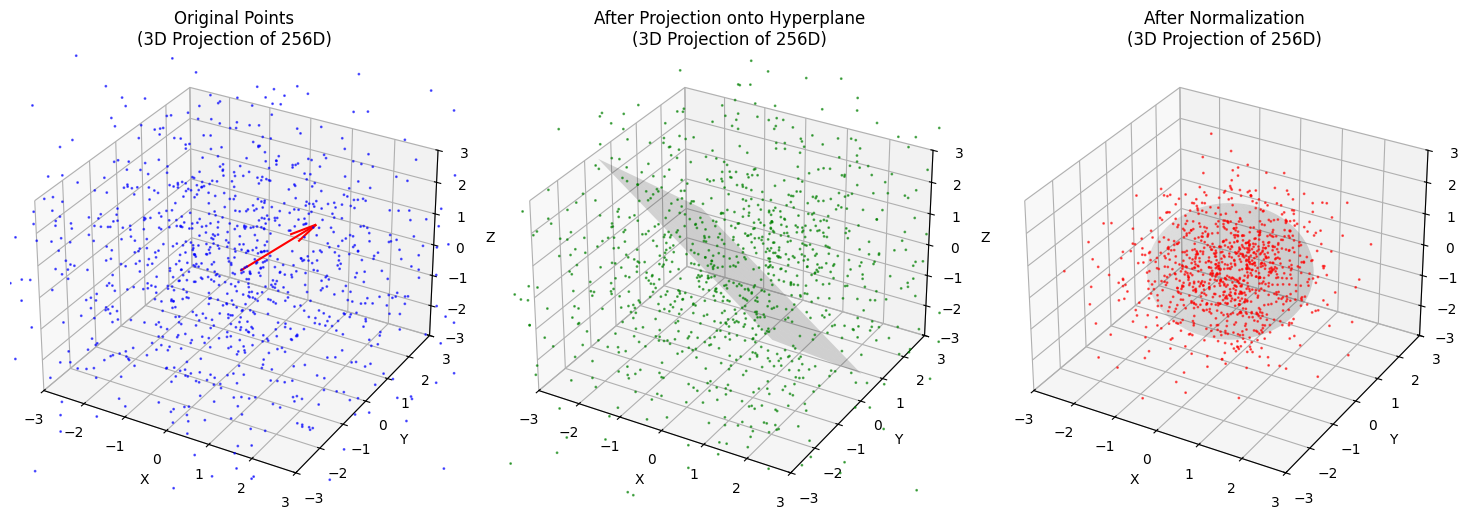

In [67]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def project_3d_to_256d(points_3d, key):
    """
    Project 3D points into 256D space while preserving their geometric structure.
    
    Args:
        points_3d: Array of shape (n_points, 3)
        key: JAX random key
    
    Returns:
        Array of shape (n_points, 256)
    """
    n_points = points_3d.shape[0]
    
    # Create an orthonormal basis for the 3D subspace in 256D
    key1, key2 = jax.random.split(key)
    random_matrix = jax.random.normal(key1, (256, 256))
    q, _ = jnp.linalg.qr(random_matrix)  # Get orthonormal basis
    basis = q[:, :3]  # Take first 3 columns as our basis
    
    # Project points into 256D space
    points_256d = points_3d @ basis.T
    
    # Add small random noise in orthogonal directions to make it more realistic
    noise = jax.random.normal(key2, (n_points, 256)) * 0.01
    # Project out the components in our 3D subspace
    for i in range(3):
        noise = noise - jnp.outer(noise @ basis[:, i], basis[:, i])
    
    return points_256d 

def project_256d_to_3d(points_256d, basis):
    """
    Project 256D points back to 3D using the same basis.
    
    Args:
        points_256d: Array of shape (n_points, 256)
        basis: Array of shape (256, 3), the basis used for the original projection
    
    Returns:
        Array of shape (n_points, 3)
    """
    return points_256d @ basis

def visualize_high_dim_layernorm():
    # Set random seed for reproducibility
    key = jax.random.PRNGKey(0)
    
    # Generate random 3D points
    n_points = 1000
    key, subkey = jax.random.split(key)
    points_3d = jax.random.normal(subkey, (n_points, 3)) * 2


    
    # Project to 256D
    key, subkey = jax.random.split(key)
    random_matrix = jax.random.normal(subkey, (256, 256))
    q, _ = jnp.linalg.qr(random_matrix)
    basis = q[:, :3]
    points_256d = project_3d_to_256d(points_3d, key)

    print(jnp.shape(points_256d))
    # Run points through the LayerNorm
    points_expanded = points[None, ...]
    new_args = ArgsAndKwargs.capture(points_expanded)
    

    points_normalized, points_centered = layer_norm(new_args)
    
    # Project back to 3D for visualization
    points_3d = np.array(points_3d)
    points_centered_3d = np.array(project_256d_to_3d(points_centered, basis))
    points_normalized_3d = np.array(project_256d_to_3d(points_normalized, basis))
    
    # Create visualization
    fig = plt.figure(figsize=(15, 5))
    
    # Plot 1: Original points
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], 
                c='b', alpha=0.6, s=1)
    ax1.set_title('Original Points\n(3D Projection of 256D)')
    
    # Add unit vector in direction [1,1,1]
    origin = np.zeros(3)
    ones_vector = np.ones(3) / np.sqrt(3)
    ax1.quiver(origin[0], origin[1], origin[2],
               ones_vector[0], ones_vector[1], ones_vector[2],
               color='r', length=2, label='[1,1,1] direction')
    
    # Plot 2: After centering
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(points_centered_3d[:, 0], points_centered_3d[:, 1],
                points_centered_3d[:, 2], c='g', alpha=0.6, s=1)
    ax2.set_title('After Projection onto Hyperplane\n(3D Projection of 256D)')
    
    # Plot plane perpendicular to [1,1,1]
    xx, yy = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
    a, b, c = 1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)
    d = 0
    zz = -(a*xx + b*yy - d)/c
    ax2.plot_surface(xx, yy, zz, alpha=0.2, color='gray')
    
    # Plot 3: After normalization
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(points_normalized_3d[:, 0], points_normalized_3d[:, 1],
                points_normalized_3d[:, 2], c='r', alpha=0.6, s=1)
    ax3.set_title('After Normalization\n(3D Projection of 256D)')
    
    # Add sphere
    r = np.sqrt(3)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax3.plot_surface(x, y, z, color='gray', alpha=0.1)
    
    # Set same scale for all plots
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([-3, 3])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
    plt.tight_layout()
    return fig

# Create and show the visualization
fig = visualize_high_dim_layernorm()
plt.show()

# Summary

On the whole, I felt like Penzai was much "closer" to the actual model than TransformerLens, operating directly on the Jax PyTree and supporting jitting and sharding. One drawback is that when you `unflaxify` a model, you lose all the methods that run on it e.g. `model.generate` so the `unflaxified` model is really cemented as a duplicate for inspecting. Equally, treescope doesn't work as well on `unflaxified` models compared to ones natively built in Penzai, wrapping every layer in `InterceptedFlaxModuleMethod`.

| Feature | Penzai | TransformerLens|
|--------------------------|--------------------------|--------------------------|
| Supported frameworks? | `flax.linen` and `penzai` | `torch` inside `transformer-lens` |
|Visualizations | Treescope - really nice interactivity especially with named axes. Missed the input-sequence visualizations but I can see the functionality is built into treescope, would need custom integration. | CircuitsVis - really love the token-level visualizations where hovering over a word in the input sequence highlights the attention patterns on the other ones.|
|Loading Models | Either build the model in Penzai or "unflaxify" it | Only comes with small pre-loaded `HookedTransformer` models, difficult to define a new one|
|Parallelism | Shard & jit model like normal | No support |
|Caching activations | No caching, only saved if hooked. More practical for larger models. | `model.run_with_cache` to save activations, less practical for larger models |
|Hooks | Use `Selector` to assign hooks directly on the JAX PyTree then run forward pass as normal | `model.run_with_hooks` has to be explictly called|
|Generate functionality | Lost when `unflaxify` is called. | `model.generate` for basic text generation|
|Bonus Features | `NamedArray` and the `copy and paste` functionality of treescope` | Easy cache all activations|
